Dataset created successfully!
   age    income  loan_amount  loan_term_month  credits_score  \
0   59  119214.0      14280.0               36          709.0   
1   49   49399.0      14238.0               60          607.0   
2   35   51164.0      16550.0               36          549.0   
3   63    9333.0      15070.0               36          577.0   
4   28   74280.0      15076.0               48          662.0   

   employment_year  prior_default marital_status             purpose  default  
0                2              0       divorced  debt_consolidation        0  
1               10              0        married  debt_consolidation        1  
2                0              0       divorced  debt_consolidation        1  
3                3              0        married  debt_consolidation        1  
4                6              0        married  debt_consolidation        0  

===LogisticRegression===
ROC AUC: 0.8917
              precision    recall  f1-score   support

  

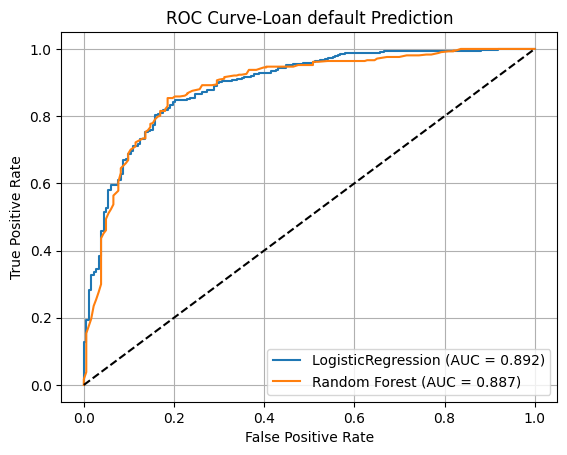

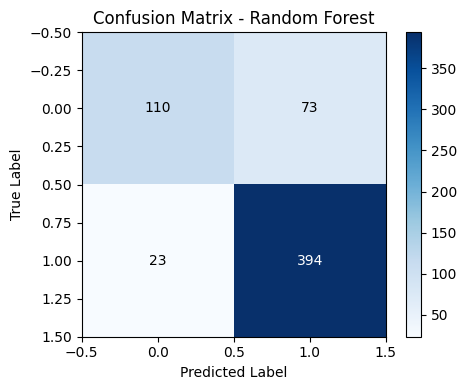

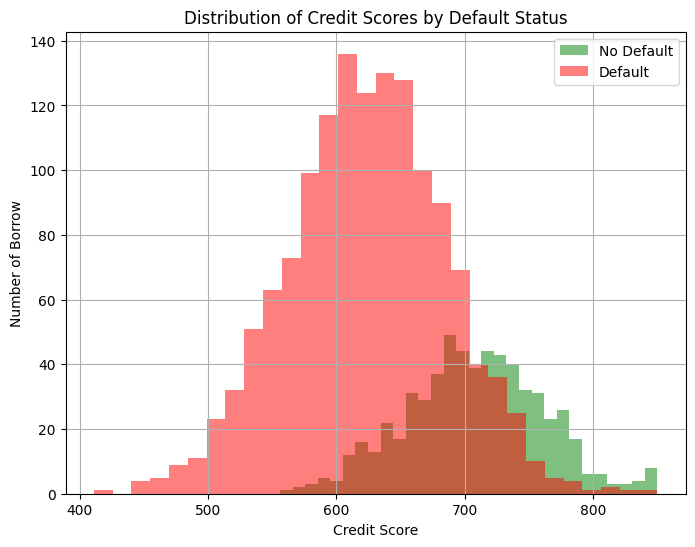

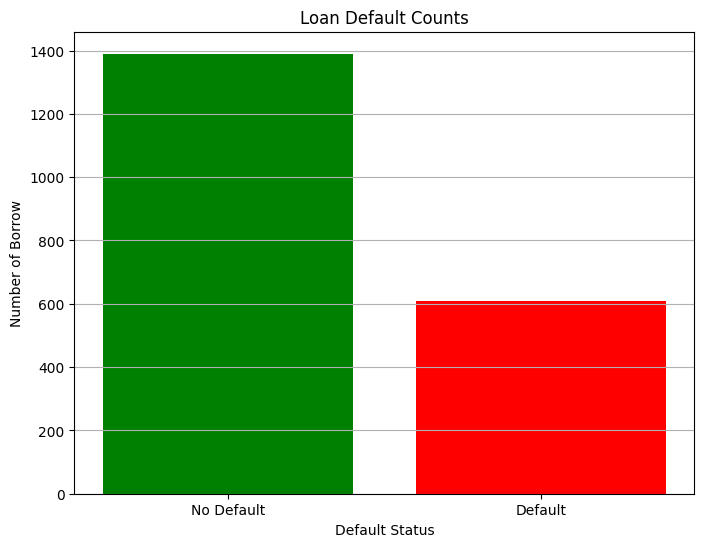

<Figure size 1200x600 with 0 Axes>

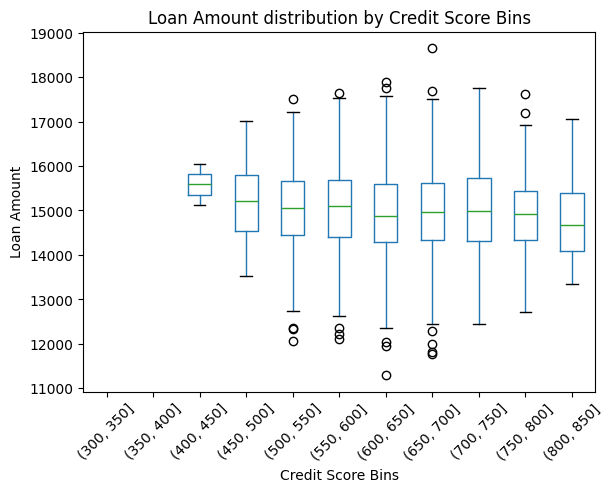

In [1]:
import numpy as np
import pandas as pd
# import seaborn as sn 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix

# dummy DATASET
np.random.seed(42)
n = 2000

age = np.random.randint(21,70,size=n)
income = np.round(np.random.normal(60000,25000,size =n)).clip(8000,300000)
loan_amount = np.round(np.random.normal(15000,1000,size=n)).clip(1000,100000)
load_term_mouth = np.random.choice([12,24,36,48,60],size=n,p=[0.05,0.15,0.4,0.25,0.15])
credits_score = np.round(np.random.normal(650,70,size=n)).clip(300,850)
employment_year = np.round(np.random.exponential(scale=3,size=n)).astype(int)
prior_default = np.random.choice([0,1],size = n,p = [0.9,0.1])
marital_status = np.random.choice(['single','married','divorced','widowed'],size=n,p=[0.45,0.45,0.07,0.03])
purpose = np.random.choice(['debt_consolidation','home_improvement','education','car','other'],size=n ,p=[0.5,0.15,0.1,0.15,0.1])


#probability of default formula

loan_income_ratio = loan_amount/(income+1)
score = (-3.0*(credits_score-650)/100.0
         +6.0*loan_income_ratio
         -0.2*employment_year
         +0.2*prior_default
         +np.where(purpose == 'debt_consolidation',0.5,0.0)
         +np.where(marital_status == 'single',0.1,0.0)
        )

prob_default = 1/(1+np.exp(-score))
default = (np.random.rand(n) < prob_default).astype(int)

df = pd.DataFrame({
    'age':age,
    'income':income,
    'loan_amount':loan_amount,
    'loan_term_month':load_term_mouth,
    'credits_score':credits_score,
    'employment_year':employment_year,
    'prior_default':prior_default,
    'marital_status':marital_status,
    'purpose':purpose,
    'default':default
})

print("Dataset created successfully!")
print(df.head())


# Data Preprocessing 
x= df.drop(columns=['default'])
y =df['default']

#categorial columns
x = pd.get_dummies(x, columns=['marital_status','purpose'], drop_first=True)

# split datasets
x_train,x_test,y_train,y_test = train_test_split(
    x,y, test_size=0.30,stratify=y , random_state= 42
    )

# Scaler numeric columns
nums_cols = ['age','income','loan_amount','loan_term_month','credits_score','employment_year','prior_default']

scaler = StandardScaler()
x_train[nums_cols] = scaler.fit_transform(x_train[nums_cols])
x_test[nums_cols] = scaler.transform(x_test[nums_cols])

# train model
lr = LogisticRegression(max_iter=1000,solver='liblinear')
rf = RandomForestClassifier(n_estimators=200,random_state=42, n_jobs=-1)

lr.fit(x_train,y_train)
rf.fit(x_train,y_train)

# Evaluate model
models = {'LogisticRegression':lr,'Random Forest':rf}
results = {}

for name,model in models.items():
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:,1]
    auc = roc_auc_score(y_test,y_prob)
    report = classification_report(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)
    results[name] = {'auc':auc,'report':report,'cm':cm}
    print(f"\n==={name}===")
    print(f"ROC AUC: {auc:.4f}")
    print(report)
    print("confusion_matrix:\n",cm)
    
    # plot ROC curve
plt.Figure(figsize=(8,6))
for name,model in models.items():
    y_prob = model.predict_proba(x_test)[:,1]
    fpr,tpr,_ = roc_curve(y_test,y_prob)
    auc = roc_auc_score(y_test,y_prob)
    plt.plot(fpr,tpr,label = f"{name} (AUC = {auc:.3f})")
        
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-Loan default Prediction')
plt.legend()
plt.grid(True)
plt.show()

#confusion matrices(random forest)
cm = results["Random Forest"]["cm"]
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]), ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()

# ploting of histogram 
plt.figure(figsize=(8,6))
plt.hist(df[df['default']==0]['credits_score'], bins=30, alpha=0.5, label='No Default', color='g')
plt.hist(df[df['default']==1]['credits_score'], bins=30, alpha=0.5, label='Default', color='r')
plt.xlabel('Credit Score')
plt.ylabel('Number of Borrow')
plt.title('Distribution of Credit Scores by Default Status')
plt.legend()
plt.grid(True)
plt.show()

# plotting bar graph
default_counts = df['default'].value_counts()
plt.figure(figsize=(8,6))
plt.bar(['No Default','Default'], default_counts, color=['g','r'])
plt.xlabel('Default Status')
plt.ylabel('Number of Borrow')
plt.title('Loan Default Counts')
plt.grid(axis='y')
plt.show()

# Create bins for credit scores (e.g., intervals of 50 points)
df['credits_score_bins'] = pd.cut(df['credits_score'], bins=range(300, 900, 50))

# Plot boxplot using binned credit score categories
plt.figure(figsize=(12,6))
df.boxplot(column='loan_amount', by='credits_score_bins', grid=False)
plt.title('Loan Amount distribution by Credit Score Bins')
plt.suptitle('')
plt.xlabel('Credit Score Bins')
plt.ylabel('Loan Amount')
plt.xticks(rotation=45)
plt.show()
